In [59]:
#import cleaned data
#need to clean the data
# one-hot encoding necessary for agency? unclear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_precision_recall_curve

In [114]:
sample = pd.read_csv('hmda_2017_nationwide_all-records_codes.csv')

In [115]:
#sample = data.sample(n=100000, random_state = 0)
sample = sample[(sample['action_taken'] == 1) | (sample['action_taken'] ==3) |
                (sample['action_taken'] ==4) | (sample['action_taken'] ==5)]
sample = sample [sample['loan_purpose'] == 1]

Cleaning data basic steps:
1) change label to binary 
    https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf
    Here, we're only saying 1 if it was approved, 0 if anything else in the data happened.
    
2) impute missing values

3) split sets

In [116]:
sample['label'] = np.where(sample['action_taken'] == 1, 1, 0)

features = sample.loc[:,['applicant_income_000s','population','minority_population','hud_median_family_income','tract_to_msamd_income','number_of_1_to_4_family_units']]
label = sample['label']

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2, random_state=0)

In [128]:
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train = impute_features.fit_transform(x_train)
#impute test set with training medians
fill_values = dict(zip(features.columns.values, impute_features.statistics_))
x_test = x_test.fillna(value=fill_values)

In [120]:
parameters = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid.fit(x_train, y_train)

results = pd.DataFrame.from_dict(grid.cv_results_)
results[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.726145,1.000000,0.726145


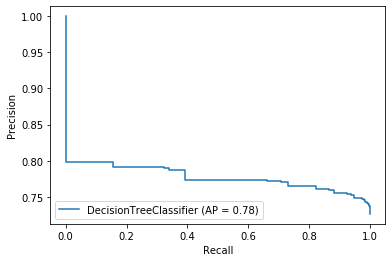

In [132]:
plot_precision_recall_curve(grid.best_estimator_, x_test, y_test)
plt.show()

Only using Census indicators provides limited accuracy. Limiting the outcome variables also, unsurprisingly, increases accuracy (not predicting pre approval, loan purchases, or approved but not accepted).

Including loan purpose, applicant one race, and sex:

In [144]:
features2 = sample.loc[:,['loan_purpose','applicant_race_1','applicant_sex','population','minority_population','hud_median_family_income','number_of_1_to_4_family_units']]
label2 = sample['label']

x_train2, x_test2, y_train2, y_test2 = train_test_split(features2, label2, test_size = .2, random_state=0)

In [145]:
features2.shape

(5859273, 7)

In [134]:
impute_features2 = SimpleImputer(missing_values=np.nan, strategy='median')
x_train2 = impute_features2.fit_transform(x_train2)
fill_values2 = dict(zip(features2.columns.values, impute_features2.statistics_))
x_test2 = x_test2.fillna(value=fill_values2)

In [99]:
parameters2 = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid2 = GridSearchCV(DecisionTreeClassifier(), parameters2, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid2.fit(x_train2, y_train2)

results2 = pd.DataFrame.from_dict(grid2.cv_results_)
results2[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744377,0.996388,0.741840
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744377,0.996388,0.741840
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744346,0.996346,0.741832
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.729607,1.000000,0.729607


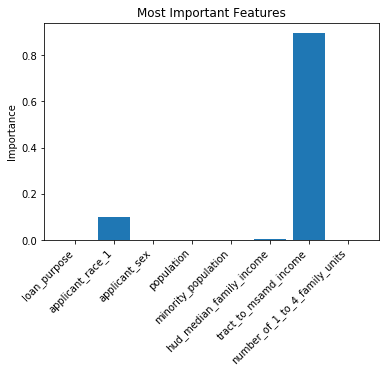

In [96]:
feature_scores = grid2.best_estimator_.feature_importances_
feature_labels = features2.columns.values
# Plot
plt.figure()
plt.bar(feature_labels, feature_scores)
plt.title('Most Important Features')
plt.ylabel('Importance')
plt.xticks(range(8), feature_labels, rotation=45, ha='right')
plt.show()

In [79]:
grid2.best_estimator_.feature_importances_

array([0.43690702, 0.11107877, 0.02931955, 0.00499694, 0.06915302,
       0.0584188 , 0.27275294, 0.01737295])

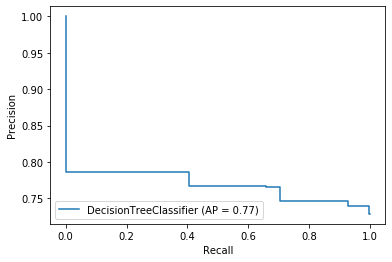

In [135]:
plot_precision_recall_curve(grid2.best_estimator_, x_test2, y_test2)

Trying a random forest model on a sample of ~30,000 observations:

In [138]:
parameters = {'random_state':[0],'n_estimators':[100,1000, 5000],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid_r = GridSearchCV(RandomForestClassifier(), parameters, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy', n_jobs = -1,verbose=2)
grid_r.fit(x_train2, y_train2)

results_r = pd.DataFrame.from_dict(grid_r.cv_results_)
results_r[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 52.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 78.1min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
3,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
4,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
5,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
6,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
7,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
8,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
9,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744683,0.997984,0.741499


In [140]:
x_train2.shape

(32634, 7)